ResNet, also known as residual neural network, refers to the idea of ​​adding residual learning to the traditional convolutional neural network, which solves the problem of gradient dispersion and accuracy degradation (training set) in deep networks, so that the network can get more and more The deeper, both the accuracy and the speed are controlled.

>Deep Residual Learning for Image Recognition Original link : <a href="https://arxiv.org/pdf/1512.03385.pdf" target="_blank">ResNet Paper</a>

**The problem caused by increasing depth**

* The first problem brought by increasing depth is the problem of gradient explosion / dissipation . This is because as the number of layers increases, the gradient of backpropagation in the network will become unstable with continuous multiplication, and become particularly large or special. small. Among them , the problem of gradient dissipation often occurs .

* In order to overcome gradient dissipation, many solutions have been devised, such as using BatchNorm, replacing the activation function with ReLu, using Xaiver initialization, etc. It can be said that gradient dissipation has been well solved

* Another problem of increasing depth is the problem of network degradation, that is, as the depth increases, the performance of the network will become worse and worse, which is directly reflected in the decrease in accuracy on the training set. The residual network article solves this problem. And after this problem is solved, the depth of the network has increased by several orders of magnitude.

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

 98% 324M/331M [00:08<00:00, 37.1MB/s]
100% 331M/331M [00:09<00:00, 38.5MB/s]


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/utkface-new.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
path='/content/utkface_aligned_cropped/UTKFace'

In [16]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os

In [30]:
age,gender,img_path=[],[],[]
for file in os.listdir(path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)
  # print(file)
  # break

In [31]:
len(img_path)

23708

In [32]:
len(gender)

23708

In [33]:
len(age)

23708

In [34]:
img_path[0]

'36_0_1_20170116205444602.jpg.chip.jpg'

In [35]:
df=pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [36]:
df.shape

(23708, 3)

In [37]:
df.head()

,age,gender,img
0,36,0,36_0_1_20170116205444602.jpg.chip.jpg
1,27,0,27_0_2_20170116172745659.jpg.chip.jpg
2,31,1,31_1_0_20170117135716524.jpg.chip.jpg
3,24,1,24_1_3_20170119165930967.jpg.chip.jpg
4,30,1,30_1_0_20170117094404388.jpg.chip.jpg


In [38]:
train_df=df.sample(frac=1,random_state=0).iloc[:20000]
test_df=df.sample(frac=1,random_state=0).iloc[20000:]

In [39]:
train_df.shape

(20000, 3)

In [40]:
test_df.shape

(3708, 3)

In [41]:
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [43]:
train_generator=train_datagen.flow_from_dataframe(train_df,directory=path,x_col='img',y_col=['age','gender'],target_size=(200,200),class_mode='multi_output')
test_generator=train_datagen.flow_from_dataframe(test_df,directory=path,x_col='img',y_col=['age','gender'],target_size=(200,200),class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [44]:
from keras.applications.resnet import ResNet50
from keras.layers import *
from keras.models import Model

In [45]:
resnet_m=ResNet50(include_top=False,input_shape=(200,200,3))

94781440/94765736 [==============================] - 0s 0us/step


In [53]:
output=resnet_m.layers[-1].output
flatten=Flatten()(output)
dense1=Dense(512,activation='relu')(flatten)
dense2=Dense(512,activation='relu')(flatten)
dense3=Dense(512,activation='relu')(dense1)
dense4=Dense(512,activation='relu')(dense2)
output1=Dense(1,activation='linear',name='age')(dense3)
output2=Dense(1,activation='sigmoid',name='gender')(dense4)

In [54]:
model_1=Model(inputs=resnet_m.input,outputs=[output1,output2])

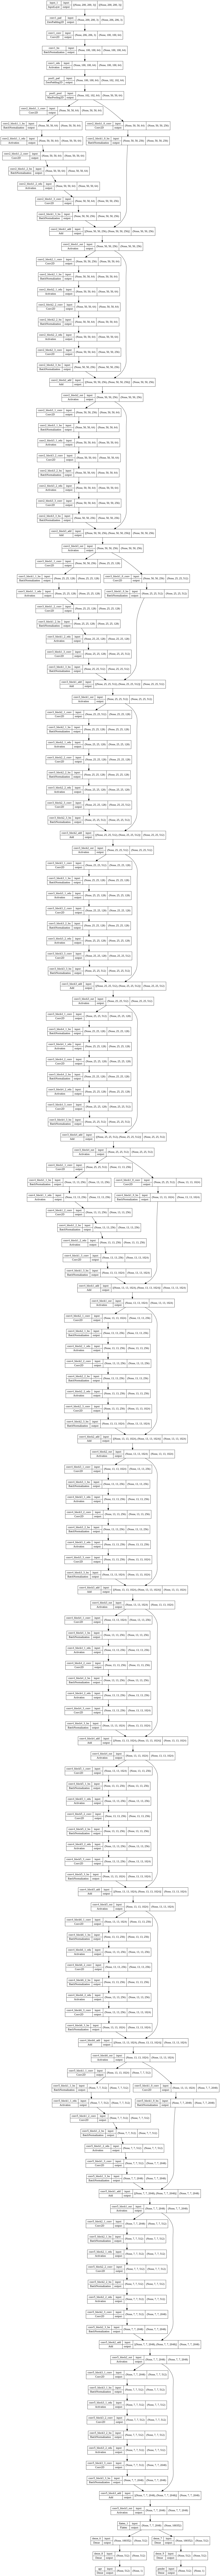

In [55]:
from keras.utils.vis_utils import plot_model
plot_model(model_1,show_shapes=True)

In [56]:
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [57]:
# for layer in resnet_m.layers:
#   layer.trainable=False

In [58]:
model_1.compile(optimizer='Adam',loss={'age':'mse','gender':'binary_crossentropy'},metrics={'age':'mse','gender':'accuracy'})

In [60]:
model_1.fit(train_generator,epochs=10,validation_data=test_generator,batch_size=32)

Epoch 1/10
625/625 [==============================] - 312s 469ms/step - loss: 293.4046 - age_loss: 292.5999 - gender_loss: 0.8050 - age_mse: 292.5999 - gender_accuracy: 0.6884 - val_loss: 386.5067 - val_age_loss: 385.7406 - val_gender_loss: 0.7660 - val_age_mse: 385.7406 - val_gender_accuracy: 0.4873
Epoch 2/10
625/625 [==============================] - 294s 470ms/step - loss: 128.5235 - age_loss: 127.9909 - gender_loss: 0.5325 - age_mse: 127.9909 - gender_accuracy: 0.7225 - val_loss: 203.1412 - val_age_loss: 202.5909 - val_gender_loss: 0.5502 - val_age_mse: 202.5909 - val_gender_accuracy: 0.6988
Epoch 3/10
625/625 [==============================] - 296s 473ms/step - loss: 111.3522 - age_loss: 110.8221 - gender_loss: 0.5302 - age_mse: 110.8221 - gender_accuracy: 0.7249 - val_loss: 196.7639 - val_age_loss: 196.2184 - val_gender_loss: 0.5455 - val_age_mse: 196.2184 - val_gender_accuracy: 0.7217
Epoch 4/10
625/625 [==============================] - 284s 454ms/step - loss: 105.9599 - age_l

In [62]:
model_1.save('age_gender_predictor.h5')

In [ ]:
tb=tf.keras.callbacks.TensorBoard(log_dir='logs/',histogram_freq=1)#,profile_batch=10000000
model_1.fit(train_generator,epochs=1,validation_data=test_generator,batch_size=32,callbacks=[tb])#,loss_weights={'age':1,'gender':99}

In [ ]:
%tensorboard --logdir logs/